In [1]:
# Volatility Arbitrage Project
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [2]:
#AAPL(1)
stock1 = yf.Ticker("AAPL")

current_price1 = stock1.history(period="1d")["Close"].iloc[-1]
print(f"The current price is {current_price1}")

expirations1 = stock1.options
print(f"Next 3 expirations: {expirations1[:3]}")

if expirations1:
    expiration1 = expirations1[0]
    chain1 = stock1.option_chain(expiration1)

    calls1 = chain1.calls.assign(option_type="call")
    puts1 = chain1.puts.assign(option_type="put")

    all_options1 = pd.concat([calls1, puts1], ignore_index=True)

    print(f"AAPL options Summary:")
    print(f"Expiration: {expiration1}")
    print(f"Total contracts: {len(all_options1)}")
    print(f"Calls: {len(calls1)}, Puts: {len(puts1)}")
    print(f"Avg Implied Vol: {all_options1['impliedVolatility'].mean():.2%}")

The current price is 274.32000732421875
Next 3 expirations: ('2025-12-26', '2026-01-02', '2026-01-09')
AAPL options Summary:
Expiration: 2025-12-26
Total contracts: 120
Calls: 66, Puts: 54
Avg Implied Vol: 119.42%


In [3]:
#MSFT(2)
stock2 = yf.Ticker("MSFT")

current_price2 = stock2.history(period="1d")["Close"].iloc[-1]
print(f"The current price is {current_price2}")

expirations2 = stock2.options
print(f"Next 3 expirations: {expirations2[:3]}")

if expirations2:
    expiration2 = expirations2[0]
    chain2 = stock2.option_chain(expiration2)

    calls2 = chain2.calls.assign(option_type="call")
    puts2 = chain2.puts.assign(option_type="put")

    all_options2 = pd.concat([calls2, puts2], ignore_index=True)

    print(f"MSFT options Summary:")
    print(f"Expiration: {expiration2}")
    print(f"Total contracts: {len(all_options2)}")
    print(f"Calls: {len(calls2)}, Puts: {len(puts2)}")
    print(f"Avg Implied Vol: {all_options2['impliedVolatility'].mean():.2%}")

The current price is 486.2799987792969
Next 3 expirations: ('2025-12-26', '2026-01-02', '2026-01-09')
MSFT options Summary:
Expiration: 2025-12-26
Total contracts: 149
Calls: 77, Puts: 72
Avg Implied Vol: 96.90%


In [4]:
r = 0.05 #risk-free rate
class black_scholes:
    def __init__(self, S: float, K: float, T: float, r: float, sigma: float, q: float = 0.0):
        self.S = float(S)
        self.K = float(K)
        self.T = max(float(T), 1e-10) #To avoid division by zero
        self.r = float(r)
        self.sigma = float(sigma)
        self.q = float(q)
        self.calculate_d1_d2()

    def calculate_d1_d2(self):
            if self.T <= 1e-10:
                self.d1 = 0.0
                self.d2 = 0.0
                return

            self.d1 = (np.log(self.S / self.K) + 
                  (self.r - self.q + 0.5 * self.sigma**2) * self.T) / \
                 (self.sigma * np.sqrt(self.T))
            self.d2 = self.d1 - self.sigma * np.sqrt(self.T)

    def call_price(self):
        from scipy.stats import norm
        return self.S * np.exp(-self.q * self.T) * norm.cdf(self.d1) - \
               self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)

    def put_price(self):
        from scipy.stats import norm
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - \
               self.S * np.exp(-self.q * self.T) * norm.cdf(-self.d1)

In [5]:
#Black Scholes pricing
T1 = (pd.to_datetime(expiration1) - datetime.utcnow()).days / 365
T2 = (pd.to_datetime(expiration2) - datetime.utcnow()).days / 365

def bs_price_1(row):
    bs = black_scholes(
        S=current_price1,
        K=row["strike"],
        T=T1,
        r=r,
        sigma=row["impliedVolatility"]
    )
    if row["option_type"] == "call":
        return bs.call_price()
    else:
        return bs.put_price()

all_options1["bs_price"] = all_options1.apply(bs_price_1, axis=1)
all_options1["mispricing"] = all_options1["lastPrice"] - all_options1["bs_price"]

def bs_price_2(row):
    bs = black_scholes(
        S=current_price2,
        K=row["strike"],
        T=T2,
        r=r,
        sigma=row["impliedVolatility"]
    )
    if row["option_type"] == "call":
        return bs.call_price()
    else:
        return bs.put_price()

all_options2["bs_price"] = all_options2.apply(bs_price_2, axis=1)
all_options2["mispricing"] = all_options2["lastPrice"] - all_options2["bs_price"]

C:\Users\User\AppData\Local\Temp\ipykernel_10984\169036037.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  T1 = (pd.to_datetime(expiration1) - datetime.utcnow()).days / 365
C:\Users\User\AppData\Local\Temp\ipykernel_10984\169036037.py:3: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  T2 = (pd.to_datetime(expiration2) - datetime.utcnow()).days / 365


In [6]:
#Checking mispricing
print("AAPL mispricing stats:")
print(all_options1["mispricing"].describe())

print("\nMSFT mispricing stats:")
print(all_options2["mispricing"].describe())

#Extreme mispricing filter
threshold1 = 0.05 * current_price1
threshold2 = 0.05 * current_price2

mispriced_aapl = all_options1[all_options1["mispricing"].abs() > threshold1]
mispriced_msft = all_options2[all_options2["mispricing"].abs() > threshold2]

print("Top mispriced AAPL options:")
print(mispriced_aapl.sort_values("mispricing", ascending=False).head())

print("Top mispriced MSFT options:")
print(mispriced_msft.sort_values("mispricing", ascending=False).head())

AAPL mispricing stats:
count    120.000000
mean      27.077500
std       21.653665
min        0.660004
25%       10.037504
50%       19.515000
75%       42.347502
max       85.739996
Name: mispricing, dtype: float64

MSFT mispricing stats:
count    149.000000
mean      35.086443
std       27.538026
min        0.609999
25%       11.919999
50%       27.800001
75%       52.660001
max      109.810001
Name: mispricing, dtype: float64
Top mispriced AAPL options:
         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
2   AAPL251226C00125000 2025-12-03 19:20:43+00:00   125.0     160.40  148.05   
0   AAPL251226C00110000 2025-12-24 15:44:18+00:00   110.0     164.17  163.05   
1   AAPL251226C00120000 2025-12-08 15:37:49+00:00   120.0     158.22  153.05   
66  AAPL251226P00120000 2025-12-19 18:09:39+00:00   120.0       0.01    0.00   
67  AAPL251226P00125000 2025-12-15 16:09:11+00:00   125.0       0.03    0.00   

       ask  change  percentChange  volume  openInterest  i

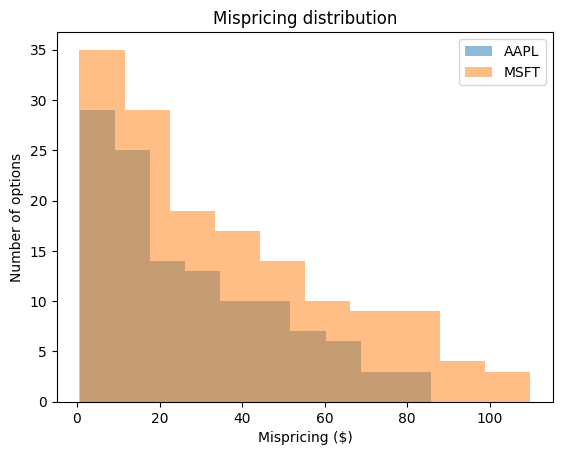

In [7]:
plt.hist(all_options1["mispricing"], alpha=0.5, label="AAPL")
plt.hist(all_options2["mispricing"], alpha=0.5, label="MSFT")
plt.legend()
plt.xlabel("Mispricing ($)")
plt.ylabel("Number of options")
plt.title("Mispricing distribution")
plt.show()